# Machine Translation using Transformers

[Video](https://www.youtube.com/watch?v=KzfyftiH7R8&list=PLtmWHNX-gukKocXQOkQjuVxglSDYWsSh9&index=18)

In [1]:
from fastai.text import *
import pdb

In [2]:
path = Path("/ml/data/fastai/translation")  # Config().data_path()/'giga-fren'

## Data

To download the data, run the following code once:

```python
! wget https://s3.amazonaws.com/fast-ai-nlp/giga-fren.tgz -P {path}
! tar xf {path}/giga-fren.tgz -C {path} 

#with open(path/'giga-fren/giga-fren.release2.fixed.fr') as f:
#    fr = f.read().split('\n')

#with open(path/'giga-fren/giga-fren.release2.fixed.en') as f:
#    en = f.read().split('\n')

re_eq = re.compile('^(Wh[^?.!]+\?)')
re_fq = re.compile('^([^?.!]+\?)')
en_fname = path/'giga-fren/giga-fren.release2.fixed.en'
fr_fname = path/'giga-fren/giga-fren.release2.fixed.fr'

lines = ((re_eq.search(eq), re_fq.search(fq)) 
         for eq, fq in zip(open(en_fname, encoding='utf-8'), open(fr_fname, encoding='utf-8')))
qs = [(e.group(), f.group()) for e,f in lines if e and f]

qs = [(q1,q2) for q1,q2 in qs]
df = pd.DataFrame({'fr': [q[1] for q in qs], 'en': [q[0] for q in qs]}, columns = ['en', 'fr'])
df.to_csv(path/'questions_easy.csv', index=False)

del en, fr, lines, qs, df # free RAM or restart the nb
```

In [3]:
def seq2seq_collate(samples:BatchSamples, pad_idx:int=1, pad_first:bool=True, backwards:bool=False):
    "Function that collects samples and adds padding. Reverses token order if needed"
    samples = to_data(samples)
    max_len_x, max_len_y = max([len(s[0]) for s in samples]), max([len(s[1]) for s in samples])
    res_x = torch.zeros(len(samples), max_len_x).long() + pad_idx
    res_y = torch.zeros(len(samples), max_len_y).long() + pad_idx
    if backwards: pad_first = not pad_first
    
    for i, s in enumerate(samples):
        if pad_first:
            res_x[i, -len(s[0]):], res_y[i, -len(s[1]):] = LongTensor(s[0]), LongTensor(s[1])
        else:
            res_x[i, :len(s[0])], res_y[i, :len(s[1])] = LongTensor(s[0]), LongTensor(s[1])
    if backwards:
        res_x, res_y = res_x.flip(1), res_y.flip(1)
    return res_x, res_y
        

In [4]:
class Seq2SeqDataBunch(TextDataBunch):
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, path:PathOrStr='.', bs:int=32, val_bs:int=None, pad_idx=1,
               pad_first=False, device:torch.device=None, no_check:bool=False, backwards:bool=False, **dl_kwargs) -> DataBunch:
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        collate_fn = partial(seq2seq_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs//2)
        
        # bugfix
        new_dl_kwargs = dl_kwargs.copy()
        new_dl_kwargs.pop('dl_tfms')
        
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **new_dl_kwargs)
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **new_dl_kwargs))
        return cls(*dataloaders, path=path, device=device, collate_fn=collate_fn, no_check=no_check)

In [5]:
class Seq2SeqTextList(TextList):
    _bunch = Seq2SeqDataBunch
    _label_cls = TextList

In [6]:
df = pd.read_csv(path/'questions_easy.csv')

In [7]:
src = Seq2SeqTextList.from_df(df, path=path, cols="fr").split_by_rand_pct().label_from_df(cols='en', label_cls=TextList)

In [8]:
src

LabelLists;

Train: LabelList (41865 items)
x: Seq2SeqTextList
xxbos xxmaj qu’est - ce que la lumière ?,xxbos xxmaj d'où venons - nous ?,xxbos xxmaj quelle sont les coordonnées ( latitude et longitude ) de xxmaj xxunk , à xxmaj terre - xxmaj neuve - xxunk ?,xxbos xxmaj quel est le groupe autochtone principal sur l’île de xxmaj vancouver ?,xxbos xxmaj quels sont les avantages et les désavantages d’utiliser un atlas en ligne comparativement à un atlas en copie papier ?
y: TextList
xxbos xxmaj what is light ?,xxbos xxmaj where did we come from ?,xxbos xxmaj what is the absolute location ( latitude and longitude ) of xxmaj badger , xxmaj newfoundland and xxmaj labrador ?,xxbos xxmaj what is the major aboriginal group on xxmaj vancouver xxmaj island ?,xxbos xxmaj what are the advantages and disadvantages of using an online atlas versus a paper atlas ?
Path: /ml/data/fastai/translation;

Valid: LabelList (10466 items)
x: Seq2SeqTextList
xxbos xxmaj qu'est - ce qu'une société canadienne ?,xxb

In [9]:
np.percentile([len(o) for o in src.train.x.items] + [len(o) for o in src.valid.x.items], 90)

29.0

In [10]:
np.percentile([len(o) for o in src.train.y.items] + [len(o) for o in src.valid.y.items], 90)

26.0

**We remove any sentences that are longer than 30 tokens:**

In [11]:
src = src.filter_by_func(lambda x,y: len(x) > 30 or len(y) > 30)

In [12]:
len(src.train), len(src.valid)

(37941, 9446)

In [13]:
data = src.databunch()

In [14]:
x, y = next(iter(data.train_dl))

In [15]:
x.shape, y.shape

(torch.Size([64, 30]), torch.Size([64, 30]))

In [16]:
from IPython.display import display, HTML

def visualize_tensor(t):
    display(HTML(pd.DataFrame(np.array(t)).to_html(index=False, header=None)))

In [17]:
visualize_tensor(x)

2,5,10,614,179,18,35,964,82,40,11,34,11,29,17,28,205,642,37,39,2787,376,41,696,1882,37,41,696,1697,9
2,5,434,11,43,42,72,5,228,3835,76,30,14,642,72,6,0,0,11,5,228,1622,10,5476,21,12,6,0,76,9
2,5,281,11,34,11,29,18,42,352,18,17,3752,16,10721,15,17,13,1222,10,104,7062,30,13,710,5,8505,5,11054,9
2,5,20,216,63,958,21,31,18,12,1067,23,5495,12,4550,25,6,1631,30,12,1754,15,12,0,10,2993,38,5,53,9
2,5,0,5,2520,5,53,5,62,98,11,58,194,16,93,36,12,228,10,195,30,14,92,30,342,58,1935,263,580,9
2,5,64,11,28,23,87,61,416,77,21,2059,20,63,441,115,3413,916,26,226,125,615,9276,38,158,16,394,535,276,9
2,5,32,22,11,28,659,66,10716,49,2462,36,13,893,25,203,682,20,36,41,3677,5895,0,8233,38,203,422,11,193,9
2,5,24,81,266,11,31,835,17,41,341,62,29,82,40,39,2653,247,376,30,13,341,6461,37,30,13,341,45,6377,9
2,5,35,154,13,865,10,13,8807,2799,26,1135,15,33,154,14,197,5082,1193,10,2653,18,5965,4579,0,15,0,25,0,9
2,5,35,22,13,782,310,21,334,31,11,193,37,261,176,10,46,5461,2762,49,574,63,166,38,158,16,1659,1124,643,9
2,5,35,7033,13,257,5,112,36,12,991,10,781,364,11,34,11,48,36,12,145,10,991,10,781,1618,15,104,1323,9


In [18]:
visualize_tensor(y)

2,5,11,58,10,1603,728,208,580,14,1016,437,2689,9,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,5,11,37,10,1190,1140,28,47,5,255,12,5,1770,17,6,3029,0,27,5,305,5,255,52,6,4612,46,47,1993,9
2,5,11,18,20,539,18,15,734,13,10,7691,231,1034,14,10,1714,12,65,5417,69,5,3602,5,7920,9,1,1,1,1
2,5,11,37,29,1276,93,20,23,18,10,6,670,1055,25,575,17,6,1445,944,28,4966,14,0,955,5,48,9,1,1
2,5,41,34,39,127,162,44,330,14,298,255,17,10,189,39,36,24,3744,9,1,1,1,1,1,1,1,1,1,1
2,5,11,576,183,13,24,103,13,143,29,57,36,24,110,20,19,6866,436,17,10,180,257,174,9,1,1,1,1,1
2,5,22,51,597,28,232,555,343,14,51,28,19,1207,12,0,232,343,9,1,1,1,1,1,1,1,1,1,1,1
2,5,11,115,12,591,45,92,24,17,0,19,269,30,64,19,1602,18,376,42,58,1870,269,26,4790,998,10,1512,9,1
2,5,11,15,19,0,487,1156,17,0,14,11,15,53,874,107,12,923,145,17,210,12,1602,18,5007,14,6,0,9,1
2,5,11,15,10,140,768,22,23,26,403,17,33,1732,31,51,158,29,1878,17,10,504,1693,1087,9,1,1,1,1,1
2,5,11,89,36,10,73,5,95,28,5,689,5,660,31,28,467,689,732,186,14,65,210,14,255,9,1,1,1,1


In [19]:
data.show_batch()

text,target
xxbos xxmaj pourquoi l'espace exigé par la liste des ingrédients n'est - il pas xxunk du calcul de la surface exposée disponible puisque l'établissement de la liste est obligatoire ?,xxbos xxmaj why is the space required for ingredient listing not removed from the calculation of xxup ads since the listing is mandatory ?
"xxbos xxmaj qu'est - ce qui se passe lorsqu'un client reçoit un xxup ra indiquant des dosimètres en retard alors , qu'en fait , il les a déjà xxunk ?","xxbos xxmaj what happens if a customer receives an xxup xxunk for late dosimeters , but the dosimeters have , in fact , been returned ?"
"xxbos xxmaj que signifie cette réussite pour vous , les militaires qui habitez les logements du xxup mdn dans les bases et les xxunk de partout au xxmaj canada ?","xxbos xxmaj what does this achievement mean for you , the xxup cf personnel who live in xxup dnd housing on bases and xxunk across xxmaj canada ?"
"xxbos xxmaj ce que je peux faire également , c'est poser la question suivante à d'autres xxmaj canadiens : « xxmaj d'où croyez - vous que vient votre nourriture ?","xxbos xxmaj what i can also do is to ask other xxmaj canadians , "" xxmaj so , where do you think your food comes from ?"
xxbos xxmaj pourquoi ne pas demander aux candidats eux - mêmes de clarifier l’état de leurs titres de compétences avant même que le processus de dotation ne prenne fin ?,xxbos xxmaj why not have candidates themselves clarify the status of their credentials prior to the end of the staffing process ?


## Transformer model

### Shifting
Transformation that shifts the targets right and adds a padding at the beginning.

In [20]:
def shift_tfm(b):
    x, y = b
    y = F.pad(y, (1, 0), value=1)  # prepends all sequences with a 1 in batch dimension
    return [x,y[:,:-1]], y[:,1:]

In [21]:
assert (shift_tfm((x,y))[0][1][:,1:] == y[:,:-1]).all()  # includes the 1s
assert (shift_tfm((x,y))[1] == y).all()  # does not include the ones

In [22]:
data.add_tfm(shift_tfm)

### Embeddings
The transformer is not reccurrent, it has no idea of the relative positions of the words. To help the transformer, we add to the input embeddings a positional encoding which is a sine of a certain frequency:

In [23]:
class PositionalEncoding(nn.Module):
    "Encode the position with a sinusoid."
    def __init__(self, d:int):
        super().__init__()
        self.register_buffer('freq', 1 / (10000 ** (torch.arange(0., d, 2.)/d)))
        
    def forward(self, pos:Tensor):
        inp = torch.ger(pos, self.freq)  # outer product
        enc = torch.cat([inp.sin(), inp.cos()], dim=-1)
        return enc

In [24]:
test_encoding = PositionalEncoding(400)  # -> gives 200 frequencies. Here you put the embedding size

In [25]:
pos = torch.arange(0, 100).float()  # -> "sentence" of length 100
res = test_encoding(pos)

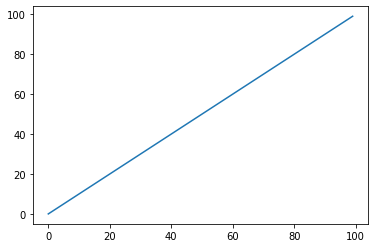

In [26]:
plt.plot(pos)

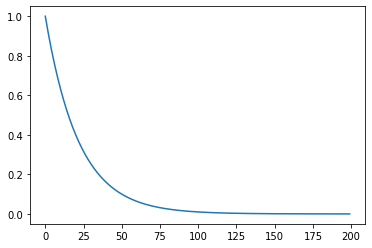

In [27]:
plt.plot(test_encoding.freq)

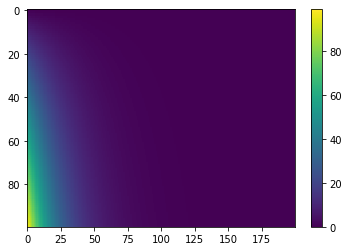

In [28]:
inp = torch.ger(pos, test_encoding.freq)
plt.imshow(inp, aspect='auto')
plt.colorbar()
plt.show()

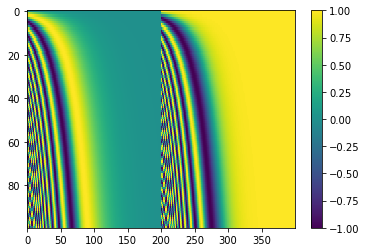

In [29]:
plt.imshow(res, aspect='auto')
plt.colorbar()
plt.show()

`res` has the shape `(100, 400)` where 100 is the length of the sentence and we have sin positional embedding of length 200 followed by cos positional embedding of length 200. We only have so many frequencies for visualization purposes, later we use fewer. 400 is the embz_sz here.

In [30]:
class TransformerEmbedding(nn.Module):
    """Embedding + positional encoding + dropout"""
    def __init__(self, vocab_sz:int, emb_sz:int, inp_p:float=0.):
        super().__init__()
        self.emb_sz = emb_sz
        self.embed = embedding(vocab_sz, emb_sz)  # initializes the embedding with trunc_normal_
        self.pos_enc = PositionalEncoding(emb_sz)
        self.drop = nn.Dropout(inp_p)
        
    def forward(self, inp):
        pos = torch.arange(0, inp.size(1), device=inp.device).float()
        return self.drop(
            self.embed(inp) * math.sqrt(self.emb_sz) + self.pos_enc(pos)
        )

In [31]:
vocab_sz = len(data.train_ds.x.vocab.itos)
te= TransformerEmbedding(vocab_sz, 300).cuda()

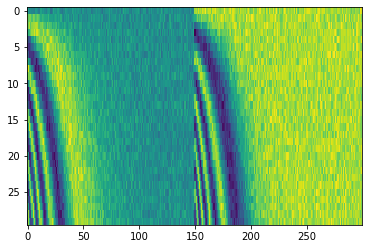

In [32]:
plt.imshow(te(x.cuda())[2], aspect='auto')

### Feed forward blocks

In [33]:
#??SequentialEx

In [34]:
#??MergeLayer

In [35]:
#??nn.LayerNorm

In [36]:
def feed_forward(d_model, d_ff, ff_p=0., double_drop=True):
    layers = [nn.Linear(d_model, d_ff), nn.ReLU()]
    if double_drop: layers.append(nn.Dropout(ff_p))
    return SequentialEx(*layers, nn.Linear(d_ff, d_model), nn.Dropout(ff_p), MergeLayer(), nn.LayerNorm(d_model))

`MergeLayer` gives a skip connection.

### Multi-head attention

![](pictures/attention.png)

**Let's start with single head attention:**

*Q, K*, and *V* stand for *query, key,* and *value*. *Q* are representing the words from sequence 1, *K*, and *V* are representing the ones from sequence 2. We will get a score from *Q, K* (scalar product) for how much weight we should give each word in sequence 2. We use this score to get a weighted average across the values.

![](pictures/query_key_1.png)

$X_1$ times the learned weight matrix $W^Q$ gives us $q_1$.

We get the score from the dot product of $q_1$ and $k_1$.
![](pictures/query_key-2.png)

Multi-head attention means that we learn several sets of these weight matrices.

When we use self attention, *Q* and *K* are the same. When we use encoder decoder attention they are different.

In [37]:
class MultiHeadAttention(nn.Module):
    """MultiHeadAttention"""
    
    def __init__(self, n_heads:int, d_model:int, d_head:int=None, resid_p:float=0., attn_p:float=0., bias:bool=True,
                 scale:bool=True):
        super().__init__()
        d_head = ifnone(d_head, d_model//n_heads)
        self.n_heads,self.d_head,self.scale = n_heads,d_head,scale
        
        self.q_wgt = nn.Linear(d_model, n_heads * d_head, bias=bias)
        self.k_wgt = nn.Linear(d_model, n_heads * d_head, bias=bias)
        self.v_wgt = nn.Linear(d_model, n_heads * d_head, bias=bias)
        
        self.out = nn.Linear(n_heads * d_head, d_model, bias=bias)
        self.drop_att,self.drop_res = nn.Dropout(attn_p),nn.Dropout(resid_p)
        self.ln = nn.LayerNorm(d_model)
        
    def forward(self, q:Tensor, k:Tensor, v:Tensor, mask:Tensor=None):
        return self.ln(q + self.drop_res(self.out(self._apply_attention(q, k, v, mask=mask))))
    
    def _apply_attention(self, q:Tensor, k:Tensor, v:Tensor, mask:Tensor=None):
        # In Encoder-Decoder Attention q is the output sentence, k and v are the input sentence.    

        # mask is not None during self attention from the output sequence. q, k, and v are all the same then

            
        bs,seq_len = q.size(0),q.size(1)
        
        # In Encoder-Decoder Attention this is the seq lenght of the output sentence
        
        wq,wk,wv = self.q_wgt(q),self.k_wgt(k),self.v_wgt(v)
        
        # wq: [bs, out_seq_len, n_heads * d_head=emb_dz], wk and wv: [bs, in_seq_len, n_heads * d_head=emb_sz]
        
        wq,wk,wv = map(lambda x:x.view(bs, x.size(1), self.n_heads, self.d_head), (wq,wk,wv))
        
        # wq: [bs, out_seq_len, n_head=8, d_head=32], wk and wv same with in_seq_len
        
        wq,wk,wv = wq.permute(0, 2, 1, 3),wk.permute(0, 2, 3, 1),wv.permute(0, 2, 1, 3)
        
        # wq: [bs, n_head, out_seq_len, d_head], wk [bs, n_head, d_head, in_seq_len], wv [bs, n_head, in_seq_len, d_head]
        
        attn_score = torch.matmul(wq, wk)
        
        # attn_score: [bs, n_head, out_seq_len, in_seq_len]
        
        if self.scale: attn_score = attn_score.div_(self.d_head ** 0.5)  # dividing by sqrt(32)
        
        if mask is not None:  # mask is not None during self attention in the decoder block
            # mask has shape [1, 1, out_seq_len, out_seq_len]
            
            attn_score = attn_score.float().masked_fill(mask, -float('inf')).type_as(attn_score)
        
        attn_prob = self.drop_att(F.softmax(attn_score, dim=-1))
        
        # attn_prob: same shape as attn_score, thus, [bs, n_head, out_seq_len, in_seq_len]
        # F.softmax(attn_score, dim=-1) gives prob distr. over input sequence
        
        attn_vec = torch.matmul(attn_prob, wv)
        
        # attn_vec: [bs, n_head, out_seq_len, d_head=32]
        
        return attn_vec.permute(0, 2, 1, 3).contiguous().contiguous().view(bs, seq_len, -1)
    
        # return: [bs, out_seq_len, n_head * d_head=d_model_emb_sz]


In [38]:
#??torch.matmul

### Masking
The transformer is not recurrent so we have to mask future time steps. Also we mask the padding as the model is not supposed to pay attention to it.

In [39]:
def get_padding_mask(inp, pad_idx:int=1):
    return None
    return (inp == pad_idx)[:, None, :, None]

In [40]:
def get_output_mask(inp, pad_idx:int=1):
    return torch.triu(inp.new_ones(inp.size(1), inp.size(1)), diagonal=1)[None, None].bool()

`torch.triu()` Returns the upper triangular part of a matrix (2-D tensor).

In [41]:
torch.triu(torch.ones(10, 10), diagonal=1).byte()

tensor([[0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.uint8)

In [42]:
x.shape

torch.Size([64, 30])

In [43]:
get_output_mask(x).shape

torch.Size([1, 1, 30, 30])

### Encoder and decoder blocks

![](pictures/Transformer.png)

![](pictures/transformer_paper.png)

**Encoder decoder**: "What word from the input is now being translated into the output language?" The syntax might be different, first word in input sentence does not have to be the first word in output sentence.

**Encoder self attention**: Useful in e.g. the sentence "The animal crossed the street because it was tired" so that the network has a chance to learn what "it" relates to. What other words in the sentence are relevant for the current concept. Same principle for decoder self attention layers.

In [44]:
#??SequentialEx

In [45]:
class EncoderBlock(nn.Module):
    """Encoder block of the Transformer architecture"""
    def __init__(self, n_heads:int, d_model:int, d_head:int, d_inner:int, resid_p:float=0., attn_p:float=0., 
                 ff_p:float=0., bias:bool=True, scale:bool=True, double_drop:bool=True):
        super().__init__()
        self.mha = MultiHeadAttention(n_heads, d_model, d_head, resid_p=resid_p, attn_p=attn_p, bias=bias, scale=scale)
        self.ff = feed_forward(d_model, d_inner, ff_p=ff_p, double_drop=double_drop)
        
        # emb_sz = d_model = 256, d_head=32, d_inner=1024
        
    def forward(self, x:Tensor, mask:Tensor=None):
        # x has shape [bs, in_seq_len/out_seq_len, emb_sz]

        y = self.mha(x, x, x, mask=mask)  # still has shape [bs, in_seq_len/out_seq_len, emb_sz]
        
        return self.ff(y)                 # still has shape [bs, in_seq_len/out_seq_len, emb_sz]
    
        # self.ff:
        # SequentialEx(
        #   (layers): ModuleList(
        #     (0): Linear(in_features=256, out_features=1024, bias=True)
        #     (1): ReLU()
        #     (2): Dropout(p=0.1, inplace=False)
        #     (3): Linear(in_features=1024, out_features=256, bias=True)
        #     (4): Dropout(p=0.1, inplace=False)
        #     (5): MergeLayer()
        #     (6): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        #   )

In [46]:
class DecoderBlock(nn.Module):
    """Decoder block of the Transformer architecture"""
    def __init__(self, n_heads:int, d_model:int, d_head:int, d_inner:int, resid_p:float=0., attn_p:float=0.,
                 ff_p:float=0., bias:bool=True, scale:bool=True, double_drop:bool=True):
        super().__init__()
        
        self.mha1 = MultiHeadAttention(n_heads, d_model, d_head, resid_p=resid_p, attn_p=attn_p, bias=bias, scale=scale)
        self.mha2 = MultiHeadAttention(n_heads, d_model, d_head, resid_p=resid_p, attn_p=attn_p, bias=bias, scale=scale)
        
        self.ff = feed_forward(d_model, d_inner, ff_p=ff_p, double_drop=double_drop)
        
        # emb_sz = d_model = 256, d_head=32, d_inner=1024
        
    def forward(self, x:Tensor, enc:Tensor, mask_in:Tensor=None, mask_out:Tensor=None):
        # x has shape [bs, out_seq_len, emb_sz]. The first time here this is the unaltered embedded target
        # enc has shape [bs, in_seq_len, emb_sz]. This is the output from the EncoderBlocks, does not change while going through decoder blocks
        # mask_out has shape [1, 1, out_seq_len, out_seq_len], mask_in is None

        y = self.mha1(x, x, x, mask_out)         # [bs, out_seq_len, emb_sz]
        z = self.mha2(y, enc, enc, mask=mask_in) # same

        return self.ff(z)                        # same

### Putting everything together

In [47]:
class Transformer(nn.Module):
    """Transformer Model"""
    def __init__(self, inp_vsz:int, out_vsz:int, n_layers:int=6, n_heads:int=8, d_model:int=256, d_head:int=32,
                 d_inner:int=1024, inp_p:float=0.1, resid_p:float=0.1, attn_p:float=0.1, ff_p:float=0.1,
                 bias:bool=True, scale:bool=True, double_drop:bool=True, pad_idx:int=1):
        super().__init__()
        
        self.enc_emb = TransformerEmbedding(inp_vsz, d_model, inp_p)
        self.dec_emb = TransformerEmbedding(out_vsz, d_model, 0.)
        
        self.encoder = nn.ModuleList([EncoderBlock(n_heads, d_model, d_head, d_inner, resid_p, attn_p, 
                                                   ff_p, bias, scale, double_drop) for _ in range(n_layers)])
        self.decoder = nn.ModuleList([DecoderBlock(n_heads, d_model, d_head, d_inner, resid_p, attn_p, 
                                                   ff_p, bias, scale, double_drop) for _ in range(n_layers)])
        
        self.out = nn.Linear(d_model, out_vsz)  # d_model = emb_sz
        self.out.weight = self.dec_emb.embed.weight
        self.pad_idx = pad_idx
    
    def forward(self, inp, out):  

        mask_in  = None  #get_padding_mask(inp, self.pad_idx)   # Would be [bs, 1, in_seq_len, 1]
        mask_out = get_output_mask (out, self.pad_idx)   # [1, 1, out_seq_len, out_seq_len] if not None
        enc,out = self.enc_emb(inp),self.dec_emb(out)    # [bs, in_seq_len/out_seq_len, emb_sz (d_model)]

        for enc_block in self.encoder:
            enc = enc_block(enc, mask_in)                # Afterwards still [bs, in_seq_len, emb_sz]
        for dec_block in self.decoder:
            out = dec_block(out, enc, mask_in, mask_out) # same with out_seq_len
        
        return self.out(out)                             # returns [bs, out_seq_len, vocab_sz]

In [48]:
in_vocab_size = len(data.train_ds.x.vocab.itos)
out_vocab_size = len(data.train_ds.y.vocab.itos)
in_vocab_size, out_vocab_size

(11352, 8128)

In [49]:
model = Transformer(in_vocab_size, out_vocab_size, d_model=256)

In [50]:
model = model.cuda()

In [51]:
i = iter(data.train_dl)

In [52]:
x, y = next(i)

In [53]:
x[0].shape, x[1].shape, y.shape

(torch.Size([64, 30]), torch.Size([64, 29]), torch.Size([64, 29]))

In [54]:
pred = model(x[0], x[1])

In [55]:
pred.shape

torch.Size([64, 29, 8128])

### Bleu metric

In [56]:
class NGram():
    def __init__(self, ngram, max_n=5000): self.ngram,self.max_n = ngram,max_n
    def __eq__(self, other):
        if len(self.ngram) != len(other.ngram): return False
        return np.all(np.array(self.ngram) == np.array(other.ngram))
    def __hash__(self): return int(sum([o * self.max_n**i for i,o in enumerate(self.ngram)]))

In [57]:
def get_grams(x, n, max_n=5000):
    return x if n==1 else [NGram(x[i:i+n], max_n=max_n) for i in range(len(x)-n+1)]

In [58]:
def get_correct_ngrams(pred, targ, n, max_n=5000):
    pred_grams,targ_grams = get_grams(pred, n, max_n=max_n),get_grams(targ, n, max_n=max_n)
    pred_cnt,targ_cnt = Counter(pred_grams),Counter(targ_grams)
    return sum([min(c, targ_cnt[g]) for g,c in pred_cnt.items()]),len(pred_grams)

In [59]:
class CorpusBLEU(Callback):
    def __init__(self, vocab_sz):
        self.vocab_sz = vocab_sz
        self.name = 'bleu'
    
    def on_epoch_begin(self, **kwargs):
        self.pred_len,self.targ_len,self.corrects,self.counts = 0,0,[0]*4,[0]*4
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        last_output = last_output.argmax(dim=-1)
        for pred,targ in zip(last_output.cpu().numpy(),last_target.cpu().numpy()):
            self.pred_len += len(pred)
            self.targ_len += len(targ)
            for i in range(4):
                c,t = get_correct_ngrams(pred, targ, i+1, max_n=self.vocab_sz)
                self.corrects[i] += c
                self.counts[i]   += t
    
    def on_epoch_end(self, last_metrics, **kwargs):
        precs = [c/t for c,t in zip(self.corrects,self.counts)]
        len_penalty = exp(1 - self.targ_len/self.pred_len) if self.pred_len < self.targ_len else 1
        bleu = len_penalty * ((precs[0]*precs[1]*precs[2]*precs[3]) ** 0.25)
        return add_metrics(last_metrics, bleu)

### Training

In [70]:
in_vocab_size = len(data.train_ds.x.vocab.itos)
out_vocab_size = len(data.train_ds.y.vocab.itos)
in_vocab_size, out_vocab_size

(11352, 8128)

In [71]:
model = Transformer(in_vocab_size, out_vocab_size, d_model=256)

In [72]:
learn = Learner(data, model, metrics=[accuracy, CorpusBLEU(out_vocab_size)], loss_func=CrossEntropyFlat())

In [73]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


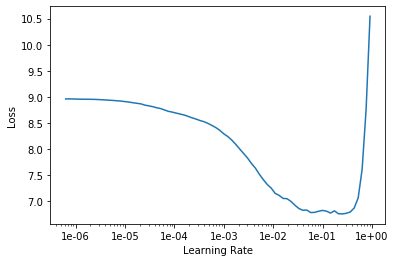

In [74]:
learn.recorder.plot()

In [75]:
learn.fit_one_cycle(8, 5e-4, div_factor=5)

epoch,train_loss,valid_loss,accuracy,bleu,time
0,2.390852,2.487914,0.615128,0.457114,01:25
1,1.944275,1.968071,0.687222,0.505634,01:25
2,1.540235,1.662174,0.723753,0.541233,01:25
3,1.342585,1.454334,0.749997,0.570900,01:26
4,1.121233,1.344774,0.766041,0.590815,01:26
5,0.953243,1.289042,0.776032,0.603985,01:26
6,0.859776,1.273365,0.779826,0.610044,01:26
7,0.802207,1.275828,0.780172,0.610689,01:26


In [95]:
def get_predictions(learn, ds_type=DatasetType.Valid):
    learn.model.eval()
    inputs, targets, outputs = [],[],[]
    with torch.no_grad():
        for xb,yb in progress_bar(learn.dl(ds_type)):
            
            assert (xb[1][:, 1:] == yb[:, :-1]).all()
            
            out = learn.model(*xb)
            for x,y,z in zip(xb[0],xb[1],out):
                inputs.append(learn.data.train_ds.x.reconstruct(x))
                targets.append(learn.data.train_ds.y.reconstruct(y))
                outputs.append(learn.data.train_ds.y.reconstruct(z.argmax(1)))
    return inputs, targets, outputs

In [96]:
inputs, targets, outputs = get_predictions(learn)

In [98]:
i = 12
print(inputs[i],"\n")
print(targets[i],"\n")
print(outputs[i],"\n")

xxbos xxmaj qu'adviendra - t - il de la xxmaj politique du xxup ct une fois le xxmaj cadre de gestion intégrée du risque approuvé et mis en œuvre ? 

xxbos xxmaj what will happen to the xxup tb policy with the approval and issuance of the xxmaj integrated xxmaj risk xxmaj management xxmaj framework ? 

xxbos xxmaj what will happen to the xxup ip xxmaj once a integrated of the of integrated integrated integrated xxmaj risk xxmaj management and framework ? 

